In [18]:
#################################################
### Auther: Asiri Amal              #############
### Title: Comic Bubble Extractor   #############
### Date : 08/02/2020               #############
#################################################

## Description:
* This version uses free OCR (optical Character Recognition) uses pytesseract library

In [19]:
# Imports

import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
from matplotlib import image
from os.path import splitext
from skimage.io import imread, imsave
from skimage.transform import resize
from tensorflow.python.keras import models
import pytesseract as tess

## Install

###  Execute below code by using command/conda promt in the location
pip3 install -r requirements.txt

### Download and install tesseract and s https://github.com/UB-Mannheim/tesseract/wiki

To access tesseract-OCR from any location you may have to add the directory where the tesseract-OCR binaries are located to the Path variables, probably C:\Program Files\Tesseract-OCR.

### After install,| Set the tesseract.exe path as shown as below

In [20]:
tess.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

## Please Set Below values if you want to change


In [21]:
### Set path values
# Initial path values are in the folder structure
# Input Images -> './sample'

input_path = "./sample/"
output_path = "OCR_SPACE_PYTESSERACT/"
try:
    os.mkdir(output_path)
    print("Output File: {:s} has been created".format(output_path))
except FileExistsError:
    print("File Already Exists...!")

Output File: OCR_SPACE_PYTESSERACT/ has been created


In [22]:
imglist = os.listdir(input_path)
imageList = [(lambda x: input_path +x)(x) for x in imglist]

In [23]:
#######################################################

In [24]:
def plot(img):
    plt.figure(figsize = (15,20))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [25]:
def remove_dup(croppedImageDimList):
    for j in croppedImageDimList:
        x1 = j[0]
        y1 = j[1]
        x2 = j[2]
        y2 = j[3]
        for i in croppedImageDimList:
            x3 = i[0]
            y3 = i[1]
            x4 = i[2]
            y4 = i[3]
            if (x1 > x3) and  (x2 <= x4) and (y1 >= y3) and (y2 <= y4):
                croppedImageDimList.remove(j)
                break

In [26]:
#Check if the text boxes are inside the given box

def inside_check(outer_box, inner_box_list):
    x1 = outer_box[0]
    y1 = outer_box[1]
    x2 = outer_box[2]
    y2 = outer_box[3]
    
    inside_boxes = []
    inside = False
    count = 0
    for i in inner_box_list:
        x3 = i[0]
        y3 = i[1]
        x4 = i[2]
        y4 = i[3]
        if (x1 < x3) and (x2>x4) and (y1<y3) and (y2>y4):
            inside = True
            count += 1
            inside_boxes.append(i)
            
    return inside, count, inside_boxes

In [27]:
#Get all text boxes in the img

def get_text_boxes(img):
    h, w, _ = img.shape # assumes color image

    # run tesseract, returning the bounding boxes
    boxes = pytesseract.image_to_boxes(img) # also include any config options you use

    text_boxes = []

    # draw the bounding boxes on the image
    for b in boxes.splitlines():
        b = b.split(' ')
        x1 = int(b[1])
        y1 = h - int(b[2])
        x2 = int(b[3])
        y2 = h - int(b[4])
        text_boxes.append([x1, y1, x2, y2])
    
    return text_boxes

In [28]:
# Tesseract OCR
def OCR(img):
    text = tess.image_to_string(img)
    tes =  text.replace('\r', ' ')
    tes = tes.replace("\n", " ")
    length = len(tes)
    return tes, length

In [29]:
# find all speech bubbles in the given comic page and return a list of cropped speech bubbles (with possible false positives)
def findSpeechBubbles(imagePath, method = 'simple'):
    color = (255, 0, 0) 
    # read image
    image = cv2.imread(imagePath)

    # gray scale
    imageGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # filter noise
    imageGrayBlur = cv2.GaussianBlur(imageGray,(3,3),0)
    if method != 'simple':
        # recognizes more complex bubble shapes
        imageGrayBlurCanny = cv2.Canny(imageGrayBlur,50,500)
        binary = cv2.threshold(imageGrayBlurCanny,235,255,cv2.THRESH_BINARY)[1]
    else:
        # recognizes only rectangular bubbles
        binary = cv2.threshold(imageGrayBlur,235,255,cv2.THRESH_BINARY)[1]
    # find contours
    contours = cv2.findContours(binary,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)[0]
    # get the list of cropped speech bubbles
    croppedImageList = []
    croppedImageDimList = []
    for contour in contours:
        rect = cv2.boundingRect(contour)
        [x, y, w, h] = rect
        start_point = (x,y) 
        end_point = (x+w, y+h)
        # filter out speech bubble candidates with unreasonable size
       
        if w < 400 and w > 60 and h < 500 and h > 25:
            croppedImage = image[y:y+h, x:x+w]
            croppedImageDim = [x, y, x+w, y+h]
            
            tes, length = OCR(croppedImage)
            if length >=2 :
                croppedImageDimList.append(croppedImageDim)
            
            croppedImageList.append(croppedImage)

    remove_dup(croppedImageDimList)
    remove_dup(croppedImageDimList)
    
    for i in croppedImageDimList:
        img = cv2.rectangle(image, (i[0], i[1]), (i[2], i[3]), color, 5) 

    return croppedImageList, croppedImageDimList, img

In [30]:
for i in range(len(imageList)):
    output_image = output_path +imglist[i]+".jpg"
    croppedImageList, croppedImageDimList, img = findSpeechBubbles(imageList[i])
    cv2.imwrite(output_image, img)
    print("Image \"{:s}\" Has been saved.. Number of Images Saved : {:d}".format(output_image, i+1))

Image "OCR_SPACE_PYTESSERACT/sample-0.png.jpg" Has been saved.. Number of Images Saved : 1
Image "OCR_SPACE_PYTESSERACT/sample-1.png.jpg" Has been saved.. Number of Images Saved : 2
Image "OCR_SPACE_PYTESSERACT/sample-10.png.jpg" Has been saved.. Number of Images Saved : 3
Image "OCR_SPACE_PYTESSERACT/sample-11.png.jpg" Has been saved.. Number of Images Saved : 4
Image "OCR_SPACE_PYTESSERACT/sample-12.jpg.jpg" Has been saved.. Number of Images Saved : 5
Image "OCR_SPACE_PYTESSERACT/sample-13.jpg.jpg" Has been saved.. Number of Images Saved : 6
Image "OCR_SPACE_PYTESSERACT/sample-14.jpg.jpg" Has been saved.. Number of Images Saved : 7
Image "OCR_SPACE_PYTESSERACT/sample-15.jpg.jpg" Has been saved.. Number of Images Saved : 8
Image "OCR_SPACE_PYTESSERACT/sample-16.jpg.jpg" Has been saved.. Number of Images Saved : 9
Image "OCR_SPACE_PYTESSERACT/sample-17.jpg.jpg" Has been saved.. Number of Images Saved : 10
Image "OCR_SPACE_PYTESSERACT/sample-18.jpg.jpg" Has been saved.. Number of Images

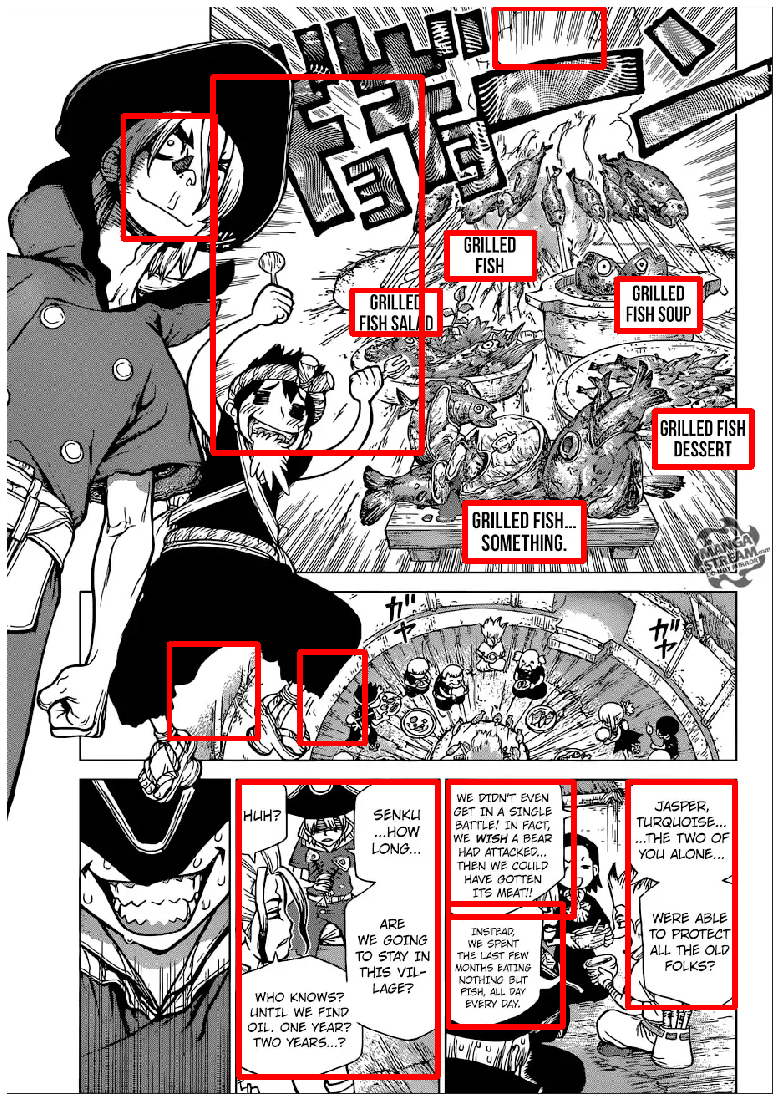

In [31]:
plot(img)